# ROI-Drawing Tutorial

This notebook walks through the process of drawing ROIs on a subject's cortical surface using neuropythy. This notebook demonstrates how to draw ROI lines for V1, V2, and V3 then to collapse them into a sensible set of ROIs and to export these ROIs to an MGZ file. For convenience, we use a subject from [Benson and Winawer (2018)](https://doi.org/10.7554/eLife.40224), which is automatically included in neuropythy's datasets--the data will be automatically downloaded from the [OSF](https://osf.io/) if you don't already have it. Alternately, you could use an HCP subject or your own subject (but this tutorial does not show how to load these data). To use the defaultt subject, all you need is an internet connection.

**Author**: &nbsp;&nbsp; [Noah C. Benson](mailto:nben@uw.edu)  
**Date**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; May 5, 2020  
**Link**: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [noahbenson/neuropythy-tutorials](https://github.com/noahbenson/neuropythy-tutorials)

## Setup

To start with, we need to import various libraries. These include, first, neuropythy itself, and, second, the matplotlib/pyplot libraries for 2D plotting. We also import various utility libraries like os and sys.

Note that we setup some options for matplotlib in the cells following our library-import cell. This is due to bugs in previous versions of matplotlib/jupyter that caused problems when the configuration was set in the same cell as the import.

In [1]:
# Import some standard/utility libraries:
import os, sys, six # six provides python 2/3 compatibility

# Import our numerical/scientific libraries, scipy and numpy:
import numpy as np
import scipy as sp

# The neuropythy library is a swiss-army-knife for handling MRI data, especially
# anatomical/structural data such as that produced by FreeSurfer or the HCP.
# https://github.com/noahbenson/neuropythy
import neuropythy as ny

# Import graphics libraries:
# Matplotlib/Pyplot is our 2D graphing library:
import matplotlib as mpl
import matplotlib.pyplot as plt

# We also import ipyvolume, the 3D graphics library used by neurropythy, for 3D
# surface rendering (optional).
import ipyvolume as ipv

In [2]:
# These "magic commands" tell matplotlib that we want to plot figures inline and
# That we are using qt as a backend; due to bugs in certain versions of
# matplotlib, we put them in a separate cell from the import statements above
# and the configuration statements below.
%gui qt
%matplotlib inline

In [3]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['Helvetica Neue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

## Choose a Subject

We need a subject whose ROIs we are going to draw. This notebook uses the subject 'S1202' from from [Benson and Winawer (2018)](https://doi.org/10.7554/eLife.40224), which neuropythy will automatically download for you. Note that the first time you download this, it will likely take some time as neuropythy needs to download and unzip most of the dataset. Additionally, note that if you don't have a path configured for the neuropythy config item `'data_cache_root'`, these data will be downloaded fresh each time you run the notebook (and will be auto-deleted when your python kernel exits). To check this, you can look at `ny.config['data_cache_root']`. This can be set to a valid directory to store various neuropythy auto-downloaded data. The file `~/.npythyrc` containing a dictionary in JSON format may be given the key `"data_cache_root"` to ensure that this configuration is preserved across sessions. The data downloaded by neuropythy to this directory may be deleted without consequence (aside from needing to re-download it again later).

In [4]:
sid = 'S1202'
# Note: This may take awhile to download if you have not downloaded these
# data previously (~9 GB once extracted).
sub = ny.data['benson_winawer_2018'].subjects['S1202']

We will look at just the LH in this tutorial (but the RH is basically the same).

In [5]:
h = 'lh'
hem = sub.hemis[h]

## Make a 2D Projection

To draw ROIs, we need a 2D plot of the surface tha we can click around. To make this, we will need to use a map-projection that constructs a 2D triangle mesh from the 3D spherical triangle mesh associated with the relevant hemisphere. We can do this in a few ways:
1. We can use `ny.to_flatmap('occipital_pole', hemisphere)`: this will create a flatmap that has been aligned with FreeSurfer's _fsaverage_ hemisphere; it is easy and guarantees that the patch of the occipital cortex that you see in every subject is approximately equivalent. However, it distorts the subject's mesh somewhat to align their hemisphere with the _fsaverage_ hemisphere.
2. We can make our own map-projection. There are a number of ways of doing this, but generally, to make a flatmap projection, you need a few things:
   1. The 3D point that should end up at the center of the 2D map.
   2. The 3D point that should end up along the positive x-axis of the map.
   3. The kind of projection (usually 'orthogonal' but alternately 'equirectangular' or 'mercator').
   4. The radius of the map, in radians of the 3D sphere from which the map is made.

   Given all of these things, you can use the hemisphere's method `projection()` to construct a map-projection. The easiest way to construct a map of the visual cortex that does not use the _fsaverage_ alignment is to use the hemisphere's `mask_projection()` method, which, given a mask (such as `('prf_visual_area', (1,2,3))` for V1, V2, and V3), will make a projection that is centered at the geometric middle of the given mask.
   
In this notebook, we will just use method 1 above, which is by far the simplest.

(-85.97261711630495, 85.91016602082378, -85.91114028076727, 85.88763415364389)

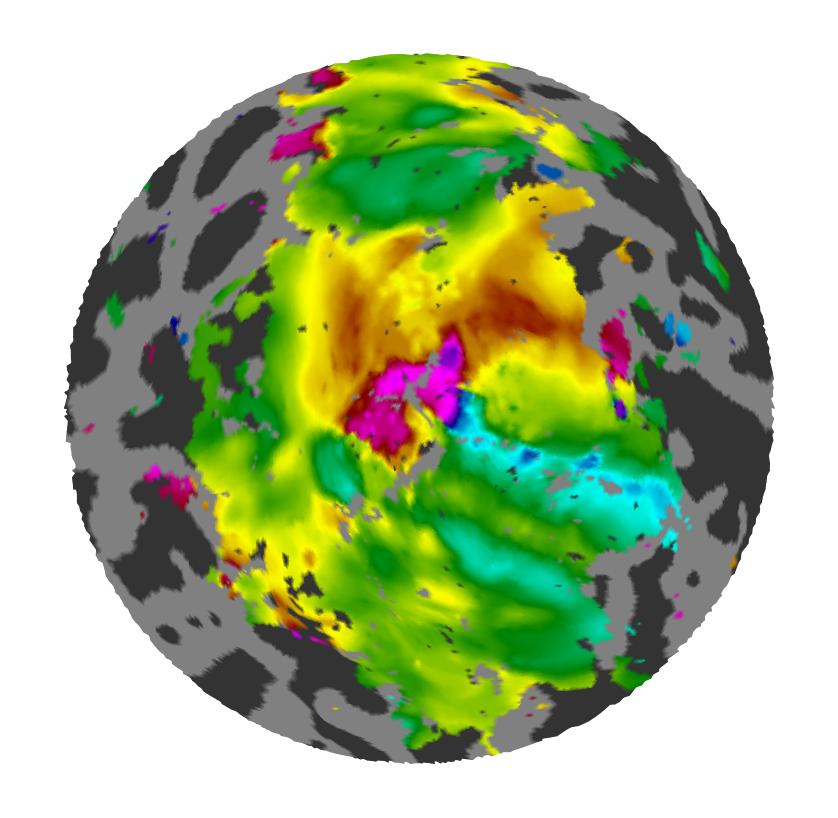

In [6]:
flatmap = ny.to_flatmap('occipital_pole', hem)

# Go ahead and plot the flatmap just to test that it worked.
# We plot polar angle in this case.
(fig,ax) = plt.subplots(1,1, figsize=(3.5,3.5), dpi=4*72)
ny.cortex_plot(flatmap, color='prf_polar_angle', mask=('prf_variance_explained', 0.1, 1),
               axes=ax)
ax.axis('equal')
ax.axis('off')

## Draw the ROIs

Neuropythy has a builtin ROI drawer; however, because matplotlib and Jupyter do not give you very much control over interactivity in the notebook, and because neuropythy uses the notebook interface for ROI drawing, the interface is fairly programmatic. The following cells will walk through how to do simple path and ROI tracing using neuropythy and how to calculate cortical magnification from these paths and ROIs.

One of the first requirements of the ROI-drawer is that we use `matplotlib notebook` mode. Usually, we plot in notebooks using `inline` mode, which simply puts images into our notebook. In `notebook` mode, these images may be interactive. However, `notebook` mode isn't optimal for non-interactive notebooks and plots, so we will set it here, using a "magic-command", just before evaluating the ROI-drawing cells.

In [11]:
# If you are using JupyterLab instead of just Jupyter, see this stackexchange question
# about using matplotlib notebook:
# https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab
%matplotlib notebook

We've already created our flatmap for plotting. When drawing the ROis, however, we would like to be able to cycle through a few plots: polar angle, eccenticity, and curvature. The ROI-drawer supports this--we just make the plots ahead of time and provide them as a list to the ROI drawer.

Another idiosyncracy of the jupyter/matplotlib interface is that we will need to reevaluate the ROI-drawing cell (below) once for each distinct ROI we are drawing. Basically, we setup the cell below to trace the first ROI; once that's done, the object we created gets finalized, and we run the cell again with a new ROI number. When we rerun the cell, it will automatically place the lines we drew in the first ROI on the flatmap so that we know where we clicked.

Note that we will probably want the ROIs we draw to overlap a little bit, even through they are adjacent but non-overlapping in the brain. This is fine--we will merge the ROIs together in a way that removes the intersections. If we draw the V1 ROI first and the V2 ROI second with V2 largely overlapping V1, when we merge the ROIs, we will remove all of the overlapping portion from V2 (the later ROI).

The way the following cell works is that we evaluate it once for each of the ROIs we're going to draw. We draw V1 first then V2, then V3. We update the name of the ROI we're drawing (at the top of the cell) each time we draw a new ROI (so that the resulting trace gets stored in a new place). Once we've evaluated this cell and have a plot on which to click ROI points, the ROI-drawing controls are as follows:
* &lt;**CLICK**&gt; anywhere on the plot to add a point to the path-trace
* **CTRL**-&lt;**CLICK**&gt; anywhere to add the final point of the path-trace, close the path, and end ROI-drawing for this ROI (this will finalize the path-trace)
* **SHIFT**-&lt;**CLICK**&gt; anywhere to remove the previously clicked point (backspace)
* **TAB** to cycle between the various plots provided

If, during the drawing, you make a mistake such that it's easier to start over, you can just reevaluate the cell before issueing a CTRL-click.

In [ ]:
roi = 1 
# The second time you run this cell, change the above line to
# `roi = 2`; the third time, change it to `roi = 3`.

if roi == 1: traces = {}

# Go ahead and setup the figure and axes onto which we will plot:
(fig,ax) = plt.subplots(1,1, figsize=(5,5), dpi=2*72)
fig.subplots_adjust(0,0,1,1,0,0)
ax.axis('off')

# The trace_roi function will take care of the plots (which we made
# in an earlier cell) and also add the previous ROI traces:
for (k,v) in six.iteritems(traces):
    if v is None or not v.is_persistent(): continue
    (x,y) = v.points
    # Close the points in the trace:
    x = np.concatenate([x,[x[0]]])
    y = np.concatenate([y,[y[0]]])
    # Plot the trace:
    ax.plot(x, y, 'k.-', lw=0.5)

# Make the plots we want to be able to cycle through
plots = [ny.cortex_plot(flatmap, axes=ax, color='prf_polar_angle'),
         ny.cortex_plot(flatmap, axes=ax, color='prf_eccentricity'),
         ny.cortex_plot(flatmap, axes=ax)]

# Prepare the ROI-drawing machinery and create a trace object.
tr = ny.graphics.trace_roi(hem, flatmap, ax, closed=True, plot_list=plots)
# We store the trace here, but it won't be finalized until after a CTRL-click.
traces[roi] = tr

# This is sometimes necessary for notebook mode.
plt.show()